In [860]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    validation_curve,
    GridSearchCV,
)
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    QuantileTransformer,
    FunctionTransformer,
    TargetEncoder,
    MinMaxScaler,
)
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
import scipy as sp

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.compose import TransformedTargetRegressor

import time
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
import re

In [861]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,1.113943,4.946624,Leisure,None,None,6.858920,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,1.079181,5.015221,Leisure,ServiceFacility,Leisure,6.923655,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,1.623249,5.980508,Leisure,None,None,7.860859,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,1.041393,4.787609,Leisure,None,None,6.832163,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,1.278754,5.244478,Leisure,ServiceFacility,Leisure,7.151450,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,ServiceFacility,47.54067,-122.37441,0.30103,0.301030,4.261548,Leisure,None,None,5.969455,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1533,ServiceFacility,47.59625,-122.32283,0.30103,0.301030,4.204147,Leisure,None,None,5.977850,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1534,ServiceFacility,47.63644,-122.35784,0.30103,0.301030,4.119190,Leisure,ServiceFacility,Leisure,6.760867,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1535,ServiceFacility,47.52832,-122.32431,0.30103,0.301030,4.149281,Leisure,ServiceFacility,School,5.857014,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


In [862]:
energy_data = data.copy()

# Separation of training and test data

In [863]:
y_energy_use = data["SiteEnergyUse(kBtu)"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
    ],
    axis=1,
)

In [864]:
def split():
    return train_test_split(X, y_energy_use, test_size=0.2, random_state=42)

# Pipelines 

Getting a baseline measure with OneHotEncoder

In [865]:
(X_train, X_test, y_train, y_test) = split()

In [866]:
encoder = OneHotEncoder()
encoded_matrix = encoder.fit_transform(
    X_train[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)

X_train = X_train.reset_index()
X_train = X_train.join(df)
X_train.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

encoded_matrix = encoder.transform(
    X_test[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)

X_test = X_test.reset_index()
X_test = X_test.join(df)
X_test.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

In [867]:
def get_linear_regression_scores(X_train, y_train):
    model = LinearRegression()
    model = model.fit(X_train, y_train)

    train_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    test_score = cross_val_score(model, X_test, y_test, cv=5).mean()
    print("Train score: ", train_score)
    print("Test score: ", test_score)

In [868]:
get_linear_regression_scores(X_train, y_train)

Train score:  0.6636507506382983
Test score:  0.4134415292660205


Getting a baseline measure with a custom encoder that condenses all property use types to 6 features representing the categories

In [869]:
(X_train, X_test, y_train, y_test) = split()

In [870]:
encoder = OneHotEncoder()
encoded_matrix = encoder.fit_transform(
    X_train[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)
unique_categories = ["Leisure", "MedicalFacility", "School", "ServiceFacility", "Store"]
grouped = df.groupby(level=0, axis=1).sum()

categorized_properties = grouped[unique_categories]
categorized_properties = categorized_properties.applymap(lambda x: 1 if x > 1 else x)


X_train = X_train.reset_index()
X_train = X_train.join(categorized_properties)
X_train.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

encoded_matrix = encoder.transform(
    X_test[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)
unique_categories = ["Leisure", "MedicalFacility", "School", "ServiceFacility", "Store"]
grouped = df.groupby(level=0, axis=1).sum()

categorized_properties = grouped[unique_categories]
categorized_properties = categorized_properties.applymap(lambda x: 1 if x > 1 else x)


X_test = X_test.reset_index()
X_test = X_test.join(categorized_properties)
X_test.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

In [871]:
get_linear_regression_scores(X_train, y_train)

Train score:  0.6509787395261905
Test score:  0.44923921567403624


The train results with OneHotEncoder are slightly better but the test scores are better using the custom encoder

### Testing pipelines

Defining the different possible preprocessing operations

In order to use the custom encoder in a pipeline, we need to create a new CustomOneHotEncoder Class

In [872]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.unique_categories = [
            "Leisure",
            "MedicalFacility",
            "School",
            "ServiceFacility",
            "Store",
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        encoded_array = encoder.fit_transform(X)

        labels = [category for sublist in encoder.categories_ for category in sublist]

        df = pd.DataFrame(encoded_array, columns=labels)
        grouped = df.groupby(level=0, axis=1).sum()

        try:
            categorized_properties = grouped[self.unique_categories]
        except KeyError as e:
            key = re.findall(r"'(.*?)'", e.args[0])[0]
            grouped[key] = 0
            categorized_properties = grouped[self.unique_categories]

        return np.array(categorized_properties.applymap(lambda x: 1 if x > 1 else x))

Let's define the possible preprocessing operations to test in the pipeline:

In [873]:
categorical_features = make_column_selector(dtype_include=object)
numerical_features = make_column_selector(dtype_include=np.number)

onehot_encoder = (
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    categorical_features,
)

custom_onehot = (CustomOneHotEncoder(), categorical_features)

target_encoder = (TargetEncoder(), categorical_features)

kBest = (SelectKBest(k=5), numerical_features)
variance_threshold = (VarianceThreshold(threshold=0.01), numerical_features)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

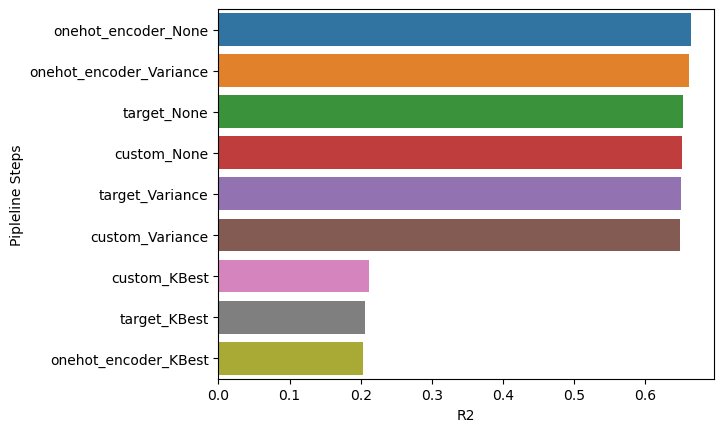

In [875]:
def build_and_evaluate_pipelines(X, y):
    pipelines = {}
    scores = pd.DataFrame()

    for encoder in ["onehot_encoder", "target", "custom"]:
        for selector in ["KBest", "Variance", None]:
            preprocessor_steps = []

            if encoder == "onehot_encoder":
                preprocessor_steps.append(onehot_encoder)
            elif encoder == "custom":
                preprocessor_steps.append(custom_onehot)
            elif encoder == "target":
                preprocessor_steps.append(target_encoder)

            if selector == "KBest":
                preprocessor_steps.append(kBest)
            elif selector == "Variance":
                preprocessor_steps.append(variance_threshold)

            preprocessor = make_column_transformer(
                *preprocessor_steps, remainder="passthrough"
            )

            model = make_pipeline(preprocessor, RobustScaler(), LinearRegression())
            steps = f"{encoder}_{selector}"
            pipelines[steps] = model

    for steps, pipeline in pipelines.items():
        score = cross_val_score(pipeline, X_train, y_train, cv=5).mean()
        scores = pd.concat(
            [
                scores,
                pd.DataFrame({"Pipleline Steps": steps, "R2": score}, index=[0]),
            ],
            ignore_index=True,
        ).sort_values(by="R2", ascending=False)

    sns.barplot(x=scores["R2"], y=scores["Pipleline Steps"])




In [ ]:
(X_train, X_test, y_train, y_test) = split()

In [ ]:
build_and_evaluate_pipelines(X_train, y_train)

Defining the target preprocessors

We can build a function to compare results of a LinearRegression using different preprocessing steps to determine which combination yields better results 

In [877]:
def build_and_evaluate_pipelines(X, y):
    pipelines = {}
    scores = pd.DataFrame()

    for encoder in ["onehot_encoder", "target", "custom"]:
        for transformer in ["log", "quantile", None]:
            for selector in ["KBest", "Variance", None]:
                preprocessor_steps = []

                if encoder == "onehot_encoder":
                    preprocessor_steps.append(onehot_encoder)
                elif encoder == "custom":
                    preprocessor_steps.append(custom_onehot)
                elif encoder == "target":
                    preprocessor_steps.append(target_encoder)

                if transformer == "log":
                    preprocessor_steps.append(log_transformer)
                elif transformer == "quantile":
                    preprocessor_steps.append(quantile_transformer)

                if selector == "KBest":
                    preprocessor_steps.append(kBest)
                elif selector == "Variance":
                    preprocessor_steps.append(variance_threshold)

                preprocessor = make_column_transformer(
                    *preprocessor_steps, remainder="passthrough"
                )

                model = make_pipeline(
                    preprocessor,
                    RobustScaler(),
                    get_target_transformer(LinearRegression(), transformer),
                )
                steps = f"{encoder}_{transformer}_{selector}"
                pipelines[steps] = model

    for steps, pipeline in pipelines.items():
        score = cross_val_score(pipeline, X_train, y_train, cv=5).mean()
        scores = pd.concat(
            [
                scores,
                pd.DataFrame({"Pipleline Steps": steps, "R2": score}, index=[0]),
            ],
            ignore_index=True,
        ).sort_values(by="R2", ascending=False)

    sns.barplot(x=scores["R2"], y=scores["Pipleline Steps"])


build_and_evaluate_pipelines(X_train, y_train)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

KeyboardInterrupt: 

In [ ]:
def build_and_evaluate_pipelines(X, y):
    pipelines = {}
    scores = pd.DataFrame()

    for encoder in ["onehot_encoder", "target", "custom", "None"]:
        for transformer in ["log", "quantile", "None"]:
            for selector in ["KBest", "Variance", "None"]:
                preprocessor = make_column_transformer(
                    (
                        onehot_encoder
                        if encoder == "onehot"
                        else custom_onehot
                        if encoder == "custom"
                        else target_encoder
                    ),
                    (log_transformer if transformer == "log" else quantile_transformer),
                    (kBest if selector == "KBest" else variance_threshold),
                )
                print(onehot_encoder)
                model = make_pipeline(
                    preprocessor,
                    RobustScaler(),
                    get_target_transformer(LinearRegression(), transformer),
                )
                steps = f"{encoder}_{transformer}_{selector}"
                pipelines[steps] = model

    for steps, pipeline in pipelines.items():
        score = cross_val_score(
            pipeline, X_train_energy_use, y_train_energy_use, cv=5
        ).mean()
        scores = pd.concat(
            [
                scores,
                pd.DataFrame({"Pipleline Steps": steps, "R2": score}, index=[0]),
            ],
            ignore_index=True,
        ).sort_values(by="R2", ascending=False)

    sns.barplot(x=scores["R2"], y=scores["Pipleline Steps"])


build_and_evaluate_pipelines(X_train_energy_use, y_train_energy_use)

(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c88c40>)
(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c88c40>)
(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c88c40>)
(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c88c40>)
(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c88c40>)
(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c88c40>)
(OneHotEncoder(handle_unknown='ignore', sparse_output=False), <sklearn.compose._column_transformer.make_column_selector object at 0x284c

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

Error in callback <function flush_figures at 0x164144670> (for post_execute):


KeyboardInterrupt: 

The pipeline that uses the custom OneHotEncoder, Log Transformation and KBest feature selection yields the best R2 score on a LinearRegression model. However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values

## Comparing metrics 

While MAE is less impacted by outliers, we will favor RMSE since this metric is more strict with large errors.

# Comparing different models 

In [ ]:
def build_pipeline(model):
    return make_pipeline(
        make_column_transformer(custom_onehot, log_transformer, kBest),
        RobustScaler(),
        TransformedTargetRegressor(regressor=model, transformer=log_function),
    )

## SVR

In [ ]:
y_train_energy_use = np.array(y_train_energy_use).ravel()
c = np.arange(0, 100)

train_score, validation_score = validation_curve(
    build_pipeline(SVR()),
    X_train_energy_use,
    y_train_energy_use,
    param_name="transformedtargetregressor__regressor__C",
    param_range=c,
    cv=10,
    scoring="r2",
)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

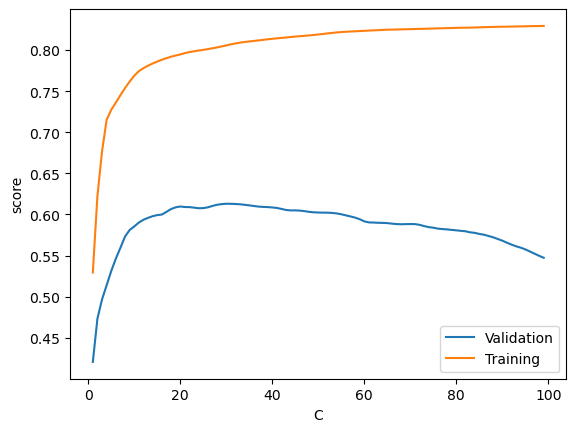

In [ ]:
plt.plot(c, validation_score.mean(axis=1), label="Validation")
plt.plot(c, train_score.mean(axis=1), label="Training")

plt.ylabel("score")
plt.xlabel("C")
plt.legend()
plt.show()

# Models

## Identifying optimal parameters with GridSearchCV

In [ ]:
def grid_search(model, params):
    scoring = {
        "r2": make_scorer(r2_score),
        "neg_mean_squared_error": make_scorer(mean_squared_error),
        "neg_mean_absolute_error": make_scorer(mean_absolute_error),
    }
    start = time.time()

    grid = GridSearchCV(
        build_pipeline(model),
        params,
        cv=5,
        scoring=scoring,
        refit="neg_mean_squared_error",
    )
    grid.fit(X_train_energy_use, y_train_energy_use)

    elapsed_time = time.time() - start
    results = {
        "Model": str(model),
        "Mean Fit Time": grid.cv_results_["mean_fit_time"].mean(),
        "Mean R2": grid.cv_results_["mean_test_r2"].mean(),
        "Mean MAE": (grid.cv_results_["mean_test_neg_mean_absolute_error"].mean()),
        "Mean RMSE": (
            np.sqrt((grid.cv_results_["mean_test_neg_mean_squared_error"].mean()))
        ),
        "Best params": str(grid.best_params_),
        "Runtime": elapsed_time,
    }

    return pd.DataFrame(results, index=[0])

In [ ]:
model_comparison = pd.DataFrame()

### SVR

In [ ]:
def build_pipeline(model):
    return make_pipeline(
        make_column_transformer(target_encoder, log_transformer, kBest),
        RobustScaler(),
        TransformedTargetRegressor(regressor=model, transformer=log_function),
    )

In [ ]:
param_grid = {
    "transformedtargetregressor__regressor__C": [1, 5, 20, 50, 100, 150],
    "transformedtargetregressor__regressor__epsilon": [0, 0.01, 0.1, 0.5, 1, 2],
    "columntransformer__selectkbest__k": [5, 10, "all"],
}

svr_results = grid_search(SVR(), param_grid)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

In [ ]:
param_grid = {
    "transformedtargetregressor__regressor__C": [1, 5, 20, 50, 100, 150],
    "transformedtargetregressor__regressor__epsilon": [0, 0.01, 0.1, 0.5, 1, 2],
    "columntransformer__selectkbest__k": [5, 10, "all"],
}

svr_results = grid_search(SVR(), param_grid)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

In [ ]:
model_comparison = pd.concat([model_comparison, svr_results], ignore_index=True)
model_comparison

,Model,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),0.048821,-0.123730,6.092957e+06,1.466801e+07,"{'columntransformer__selectkbest__k': 5, 'svr_...",33.110790
1,SVR(),0.020553,-0.123786,6.093624e+06,1.466856e+07,"{'svr__C': 1, 'svr__epsilon': 0}",5.720995
2,SVR(),0.057047,-8.780332,5.360166e+06,5.063418e+07,{'transformedtargetregressor__regressor__C': 1...,12.041815
3,SVR(),0.027938,0.235734,4.494300e+06,1.201240e+07,{'transformedtargetregressor__regressor__C': 1...,6.079540
4,SVR(),0.062821,-14252.903914,1.334299e+07,1.763442e+09,"{'columntransformer__selectkbest__k': 10, 'tra...",37.863383


### ElasticNet

In [ ]:
param_grid = {
    "transformedtargetregressor__regressor__alpha": [1e-3, 1e-2, 1e-1, 1, 10],
    "transformedtargetregressor__regressor__l1_ratio": [0, 0.3, 0.5, 0.8, 1],
    "transformedtargetregressor__regressor__max_iter": [2000],
    "columntransformer__selectkbest__k": [5, 10, "all"],
}

elastic_net_results = grid_search(ElasticNet(), param_grid)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

In [ ]:
model_comparison = pd.concat([model_comparison, elastic_net_results], ignore_index=True)
model_comparison

,Model,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),0.06062,-0.035278,4.745728e+06,1.345749e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",37.579678
1,ElasticNet(),0.04940,-0.103195,6.110672e+06,1.454789e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",54.174283


### RandomForest

In [ ]:
param_grid = {
    "transformedtargetregressor__regressor__n_estimators": [100, 120, 150, 200],
    "transformedtargetregressor__regressor__max_depth": [1, 10, 15, 20, 25, None],
    "transformedtargetregressor__regressor__min_samples_split": [2, 4, 6, 8, 10],
    "transformedtargetregressor__regressor__max_features": ["sqrt", "log2", None],
    "columntransformer__selectkbest__k": [5, 10, "all"],
}

random_forest_results = grid_search(RandomForestRegressor(), param_grid)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

In [ ]:
model_comparison = pd.concat(
    [model_comparison, random_forest_results], ignore_index=True
)
model_comparison

,Model,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),0.060620,-0.035278,4.745728e+06,1.345749e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",37.579678
1,ElasticNet(),0.049400,-0.103195,6.110672e+06,1.454789e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",54.174283
2,RandomForestRegressor(),0.269959,0.446858,3.842150e+06,1.038216e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",1520.386542


### Gradient Boosting

In [ ]:
param_grid = {
    "transformedtargetregressor__regressor__n_estimators": [100, 120, 150, 200],
    "transformedtargetregressor__regressor__loss": [
        "squared_error",
        "absolute_error",
        "huber",
        "quantile",
    ],
    "transformedtargetregressor__regressor__min_samples_split": [2, 4, 6, 8, 10],
    "transformedtargetregressor__regressor__max_features": ["sqrt", "log2", None],
    "columntransformer__selectkbest__k": [5, 10, "all"],
}

gradient_boosting_results = grid_search(GradientBoostingRegressor(), param_grid)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value enco

In [ ]:
model_comparison = pd.concat(
    [model_comparison, gradient_boosting_results], ignore_index=True
)
model_comparison

,Model,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),0.060620,-0.035278,4.745728e+06,1.345749e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",37.579678
1,ElasticNet(),0.049400,-0.103195,6.110672e+06,1.454789e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",54.174283
2,RandomForestRegressor(),0.269959,0.446858,3.842150e+06,1.038216e+07,"{'columntransformer__selectkbest__k': 5, 'tran...",1520.386542
3,GradientBoostingRegressor(),0.212347,0.559214,4.097752e+06,8.980513e+06,"{'columntransformer__selectkbest__k': 5, 'tran...",785.886029
